In [1]:
#Modelo LSTM para pronosticar la Inflación No Subyacente
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
from matplotlib import pylab, mlab, pyplot
from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
from pylab import *
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
from scipy.stats import randint
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
#Todos los títulos en times new roman
plt.rc('font', family='Times New Roman')
#
# Funciones auxiliares
#



In [2]:
#
# Lectura de los datos
#
dataset = pd.read_excel('IPC_LSTM.xlsx',sheet_name='INPCNSUB', index_col='fecha', parse_dates=['fecha'])
dataset=dataset.resample('M').last()
dataset.head()



,ipcnsub
fecha,
1989-01-31,4.874835
1989-02-28,4.839201
1989-03-31,4.846248
1989-04-30,4.963637
1989-05-31,5.086264


In [3]:
#Veamos la descripción de los datos
descripcion1=pd.DataFrame(dataset.describe())
descripcion1
descripcion1.to_csv('descripciondatos.csv')


In [22]:
descripcion1=pd.DataFrame(dataset.describe())
descripcion1

,ipcnsub
count,411.000000
mean,53.842880
std,34.990776
min,4.839201
25%,24.501971
50%,49.584732
75%,80.113781
max,131.136564


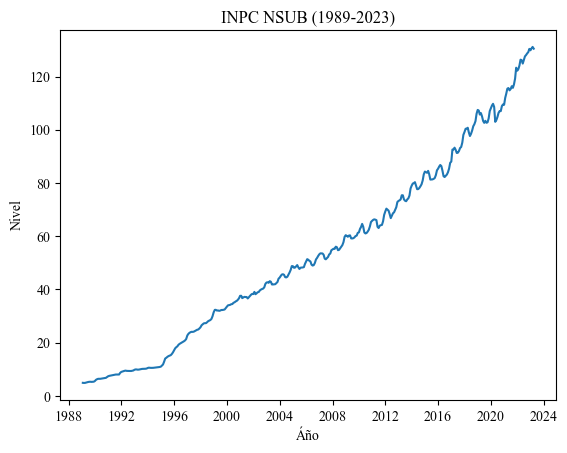

In [3]:
#Visualizamos los datos
TN= 'Times New Roman'
plt.figure()
plt.plot(dataset)
plt.ylabel('Nivel', fontname=TN)
plt.xlabel('Áño', fontname=TN)
plt.title('INPC NSUB (1989-2023)', fontname=TN)
for i in plt.get_fignums():
    plt.figure(i)
    plt.savefig('figure%d.png' % i)
plt.show()



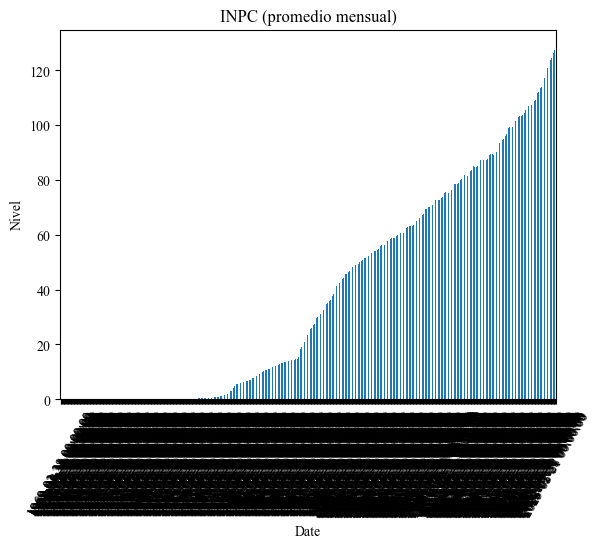

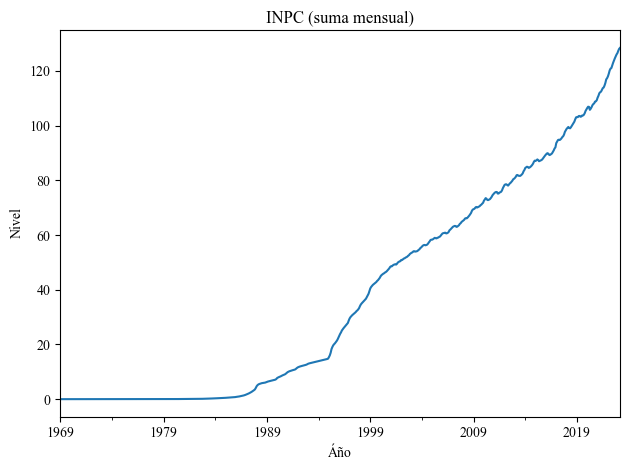

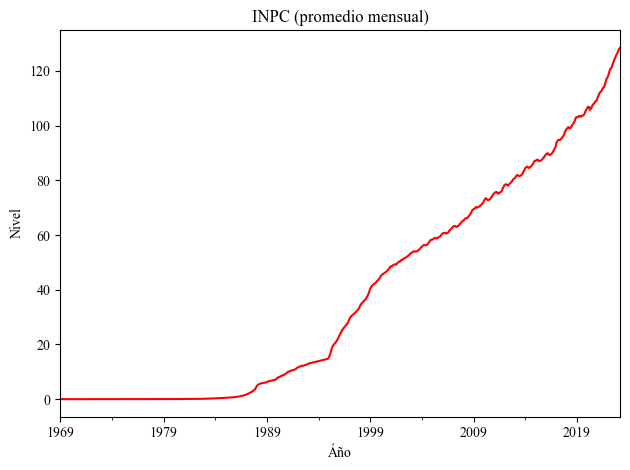

In [6]:
#Promedio mensual
dataset['INPC'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Nivel', fontname=TN)
plt.title('INPC (promedio mensual)', fontname=TN)
plt.show()
#Visualizamos la suma y el promedio
dataset.INPC.resample('M').sum().plot()
plt.ylabel('Nivel', fontname=TN)
plt.xlabel('Áño', fontname=TN)
plt.title('INPC (suma mensual)', fontname=TN)
plt.tight_layout()
plt.show()
dataset.INPC.resample('M').mean().plot(color='red') 
plt.ylabel('Nivel', fontname=TN)
plt.xlabel('Áño', fontname=TN)
plt.title('INPC (promedio mensual)', fontname=TN)
plt.tight_layout()
plt.show()




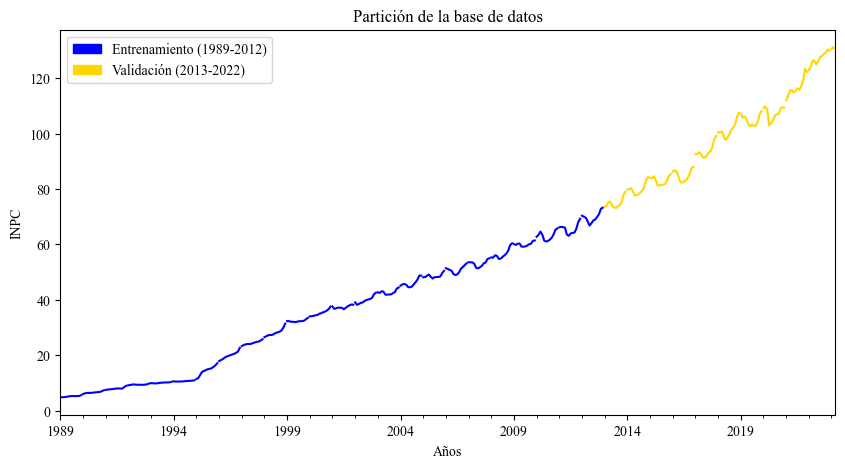

In [4]:
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 1989-2012. La validación se hará con datos de 2013-2022 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#
set_entrenamiento = dataset['1989':'2012']
set_validacion = dataset['2013':]
#Visualizamos la partición
plt.figure(figsize=(10, 5))
Entrenamiento = mpatches.Patch(color='blue', label='Entrenamiento (1989-2012)')
Prueba = mpatches.Patch(color='gold', label='Validación (2013-2022)')
set_entrenamiento.resample('Y').plot(color='blue')
set_validacion.resample('Y').plot(color='gold')
plt.legend(handles=[Entrenamiento,Prueba],loc='best')
plt.ylabel('INPC', fontname=TN)
plt.xlabel('Años', fontname=TN)
plt.title('Partición de la base de datos', fontname=TN)
plt.show()



In [7]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 3
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [8]:
#Ahora vamos a darle forma al set de prueba
set_validacion_escalado = sc.fit_transform(set_validacion)
m = len(set_validacion_escalado)
x_test = []
y_test = []
for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    x_test.append(set_validacion_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    y_test.append(set_validacion_escalado[i,0])
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape x_test para que se ajuste al modelo en Keras
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [9]:
#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 120

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dropout(0.1))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='adam', loss='mse')
hist = modelo.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), verbose=2, shuffle=False)




Epoch 1/100
9/9 - 2s - loss: 0.1860 - val_loss: 0.1364 - 2s/epoch - 258ms/step
Epoch 2/100
9/9 - 0s - loss: 0.0716 - val_loss: 0.0487 - 78ms/epoch - 9ms/step
Epoch 3/100
9/9 - 0s - loss: 0.0159 - val_loss: 0.0163 - 69ms/epoch - 8ms/step
Epoch 4/100
9/9 - 0s - loss: 0.0152 - val_loss: 0.0175 - 72ms/epoch - 8ms/step
Epoch 5/100
9/9 - 0s - loss: 0.0182 - val_loss: 0.0111 - 47ms/epoch - 5ms/step
Epoch 6/100
9/9 - 0s - loss: 0.0129 - val_loss: 0.0084 - 65ms/epoch - 7ms/step
Epoch 7/100
9/9 - 0s - loss: 0.0078 - val_loss: 0.0064 - 60ms/epoch - 7ms/step
Epoch 8/100
9/9 - 0s - loss: 0.0052 - val_loss: 0.0044 - 63ms/epoch - 7ms/step
Epoch 9/100
9/9 - 0s - loss: 0.0042 - val_loss: 0.0032 - 62ms/epoch - 7ms/step
Epoch 10/100
9/9 - 0s - loss: 0.0030 - val_loss: 0.0024 - 63ms/epoch - 7ms/step
Epoch 11/100
9/9 - 0s - loss: 0.0023 - val_loss: 0.0020 - 63ms/epoch - 7ms/step
Epoch 12/100
9/9 - 0s - loss: 0.0015 - val_loss: 0.0017 - 62ms/epoch - 7ms/step
Epoch 13/100
9/9 - 0s - loss: 0.0011 - val_loss: 

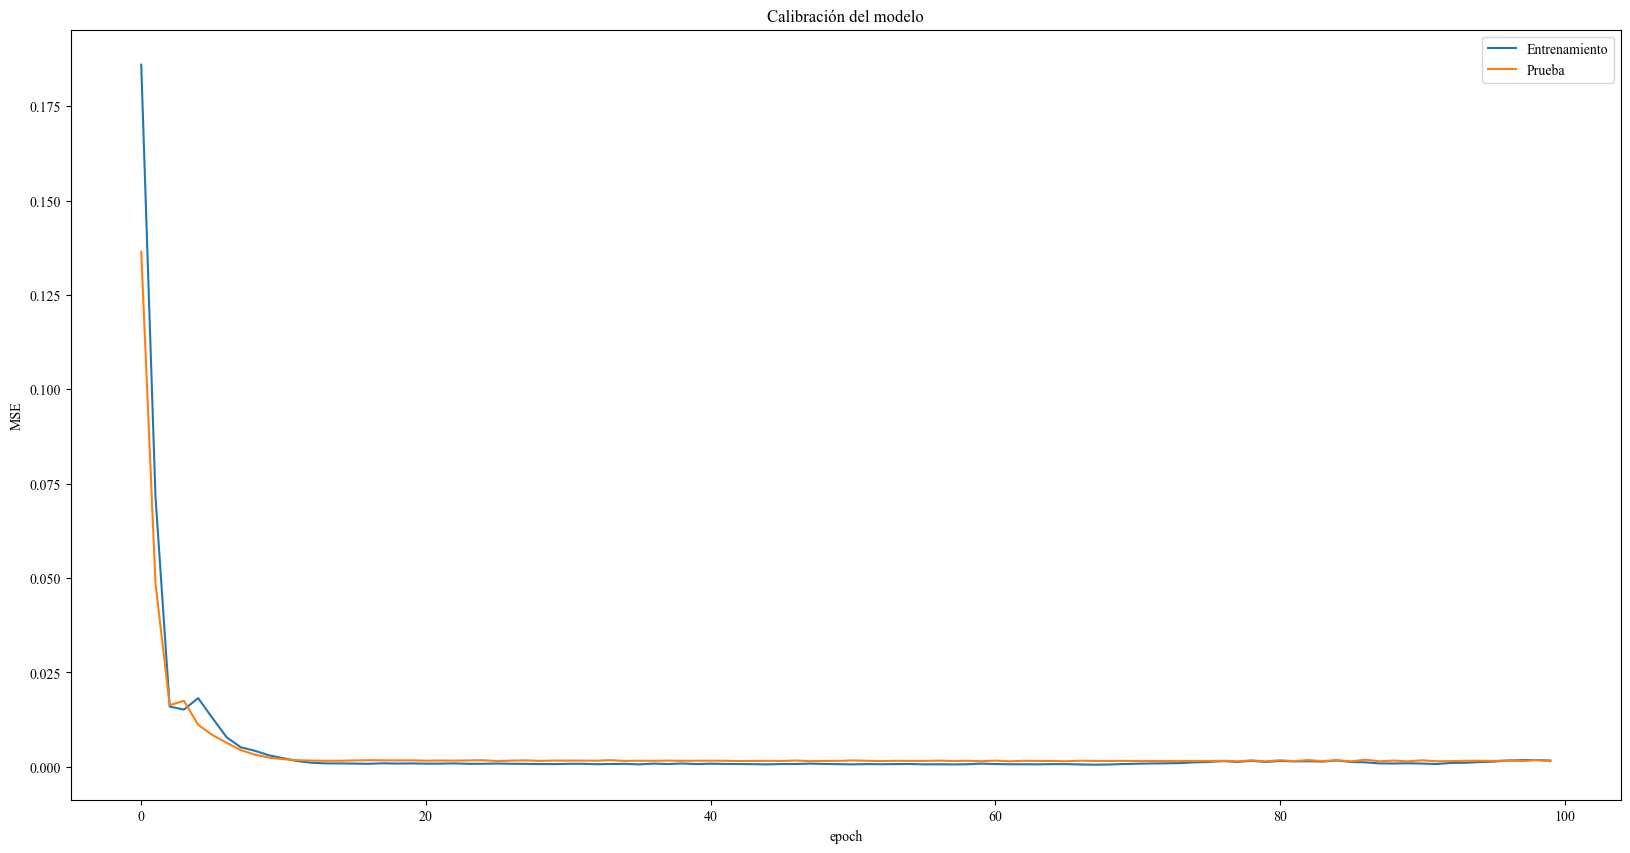

In [11]:
#Visualizar la perdida en función de los epochs
plt.figure(figsize=(20, 10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Calibración del modelo')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper right')
plt.show()


In [12]:
#Predicción de 2022
prediccion = modelo.predict(x_test)
prediccion = sc.inverse_transform(prediccion)
prediction = np.concatenate(prediccion, axis=0 ).tolist()
prediction = [item for sublist in prediccion for item in sublist]
prediction = pd.DataFrame(prediction)
rng = pd.date_range('2013-01-01 00:00:00', periods=123, freq='M')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, left_index=True, right_index=True, how='outer')
prediction.set_index('0_x')
prediction.columns = ['Date', 'ipcnsub']
prediction.set_index(['Date'], inplace=True)


4/4 [==============================] - 0s 0s/step


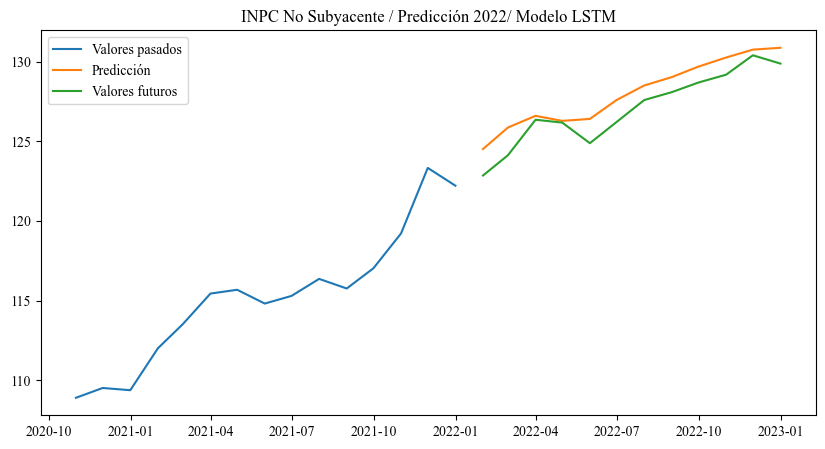

In [13]:
plt.figure(figsize=(10, 5))

item_id = "ipcnsub"
y_past = dataset[item_id]
y_pred = prediction[item_id]['2022':]
y_test = set_validacion[item_id]['2022-01':'2022-12']

plt.plot(y_past['2020-10':'2021'], label="Valores pasados")
plt.plot(y_pred, label="Predicción")
plt.plot(y_test, label="Valores futuros")
plt.title('INPC No Subyacente / Predicción 2022/ Modelo LSTM')

plt.legend();

In [14]:
pd.DataFrame(y_pred)

,ipcnsub
Date,
2022-01-31,124.510696
2022-02-28,125.863121
2022-03-31,126.596260
2022-04-30,126.281036
2022-05-31,126.403046
2022-06-30,127.590843
2022-07-31,128.501312
2022-08-31,129.028549
2022-09-30,129.688919


In [15]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred['2022-01':'2022-12'])
print('El MSE de la predicción es:', mse)

El MSE de la predicción es: 1.2563701304332666


In [16]:
#Pronóstico de 2008
df=dataset['2008-01':'2009-03']
x_total = df.values
x_total=sc.transform(x_total)
X_total= []
for i in range(time_step,len(x_total)):
    X_total.append(x_total[i-time_step:i,0])
X_total = np.array(X_total)
X_total = np.reshape(X_total, (X_total.shape[0],X_total.shape[1],1))



C:\Users\Erik Rosas\anaconda3\envs\ag\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [17]:
prediccion2= modelo.predict(X_total)
prediccion2 = sc.inverse_transform(prediccion2)
prediction2 = np.concatenate(prediccion2, axis=0 ).tolist()
prediction2 = [item for sublist in prediccion2 for item in sublist]
prediction2 = pd.DataFrame(prediction2)
rng = pd.date_range('2008-01-01 00:00:00', periods=12, freq='M')
rng = pd.DataFrame(rng)
prediction2 = pd.merge(rng, prediction2, left_index=True, right_index=True, how='outer')
prediction2.set_index('0_x')
prediction2.columns = ['Date', 'ipcnsub']
prediction2.set_index(['Date'], inplace=True)


1/1 [==============================] - 0s 16ms/step


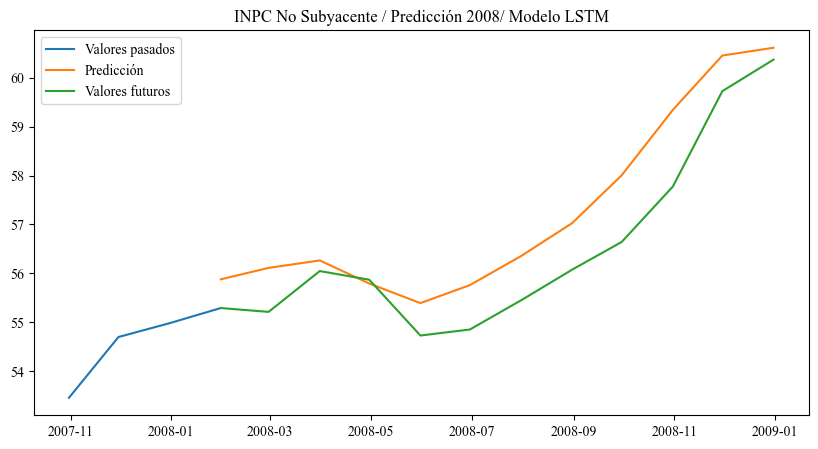

In [18]:
#graficamos el pronóstico de 2008
plt.figure(figsize=(10, 5))

item_id = "ipcnsub"
y_past = dataset[item_id]['2007-10':'2008-1']
y_pred = prediction2[item_id]['2008':]
y_test = df[item_id]['2008-01':'2008-12']

plt.plot(y_past, label="Valores pasados")
plt.plot(y_pred, label="Predicción")
plt.plot(y_test, label="Valores futuros")
plt.title('INPC No Subyacente / Predicción 2008/ Modelo LSTM')

plt.legend(loc=2);

In [19]:
mse2 = mean_squared_error(y_test, y_pred)
print('El MSE de la predicción es:', mse2)

El MSE de la predicción es: 0.7582146448583921


In [18]:
#Pronóstico de toda la serie
df1=dataset['1989':'2023']
x_total1 = df1.values
x_total1=sc.transform(x_total1)
X_total1= []
for i in range(time_step,len(x_total1)):
    X_total1.append(x_total1[i-time_step:i,0])
X_total1 = np.array(X_total1)
X_total1 = np.reshape(X_total1, (X_total1.shape[0],X_total1.shape[1],1))



C:\Users\Erik Rosas\anaconda3\envs\ag\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [19]:
prediccion3= modelo.predict(X_total1)
prediccion3 = sc.inverse_transform(prediccion3)
prediction3 = np.concatenate(prediccion3, axis=0 ).tolist()
prediction3 = [item for sublist in prediccion3 for item in sublist]
prediction3 = pd.DataFrame(prediction3)
rng = pd.date_range('1989-01-01 00:00:00', periods=408, freq='M')
rng = pd.DataFrame(rng)
prediction3 = pd.merge(rng, prediction3, left_index=True, right_index=True, how='outer')
prediction3.set_index('0_x')
prediction3.columns = ['Date', 'ipcnsub']
prediction3.set_index(['Date'], inplace=True)


13/13 [==============================] - 0s 3ms/step


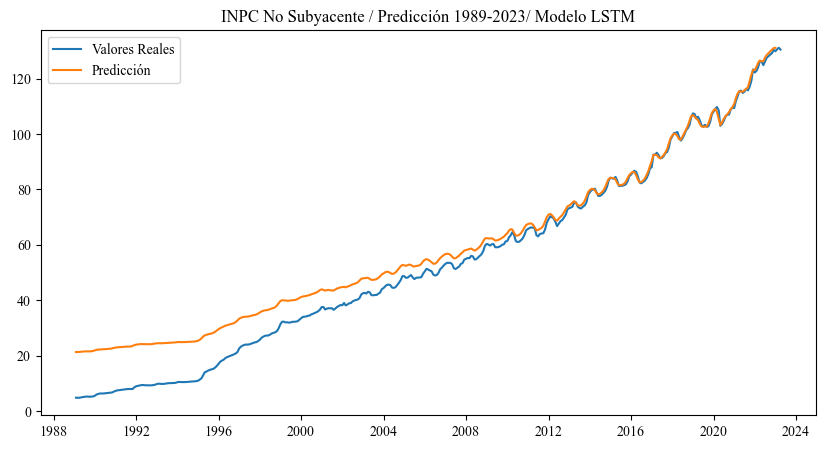

In [20]:
#graficamos el pronóstico para toda la serie
plt.figure(figsize=(10, 5))

item_id = "ipcnsub"
y_past= df1[item_id]
y_pred = prediction3[item_id]

plt.plot(y_past, label="Valores Reales")
plt.plot(y_pred, label="Predicción")
plt.title('INPC No Subyacente / Predicción 1989-2023/ Modelo LSTM')

plt.legend();